In [39]:
from monai.utils import first, set_determinism
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    AddChanneld,
    LoadImaged,
    SpatialCropd,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
    SpatialCrop,
    Crop,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
from monai.inferers import sliding_window_inference
import pandas as pd

In [40]:
in_dir = 'C:\\Users\\ChiaraFreistetter\\Desktop\\fh\\inno-organ_segmentation\\data\\KiTS-20210922T123706Z-001'
model_dir = 'C:\\Users\\ChiaraFreistetter\\Desktop\\fh\\inno-organ_segmentation\\results\\'

In [41]:
path_validation_volumes = sorted(glob(in_dir + "\\images\\**\\*.nii"))
path_validation_segmentation = sorted(glob(in_dir + "\\labels\\**\\*.nii"))

In [42]:
def match_box(data, images):
    for image in images:
        box = data[data['case'] == image['vol']]
        value = box["y1"] < box["y2"]
        if value.bool:

            box_start = box[["y1", "x1", "z1"]]
            box_start = box_start.to_numpy().astype(int)
            image["start"] = box_start

            box_end = box[["y2", "x2", "z2"]]
            box_end = box_end.to_numpy().astype(int)
            image["end"] = box_end
        else:
            box_start = box[["y2", "x2", "z1"]]
            box_start = box_start.to_numpy().astype(int)
            image["start"] = box_start

            box_end = box[["y1", "x1", "z2"]]
            box_end = box_end.to_numpy().astype(int)
            image["end"] = box_end

    return images


class cropBox(object):
    def __call__(self, img):
        try:
            trans = SpatialCropd(keys=["vol", "seg"], roi_start=img['start'][0], roi_end=img['end'][0])
        except:
            trans = SpatialCropd(keys=["vol", "seg"], roi_start=img['start'], roi_end=img['end'])
        image = trans(img)
        return image

In [43]:
validation_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_validation_volumes, path_validation_segmentation)]
validation_files = validation_files[0:9]

df = pd.read_csv("bounding_box_points.csv")
df['z1'] = 1
df["z2"] = 512

validation_files = match_box(df, validation_files)

a_max = 200
a_min = -200
spatial_size = [128, 128, 64]

validation_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Orientationd(keys=["vol", "seg"], axcodes="PLS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        cropBox(),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ]
        )

In [44]:
validation_ds = Dataset(data=validation_files, transform=validation_transforms)
validation_loader = DataLoader(validation_ds, batch_size=1)
# aug gpu berechnen
device = torch.device("cuda:0")
# model definieren
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    kernel_size = 3,
).to(device)
# anders als beim training wollen wir hier hald das gespeicherte model verwenden
sw_batch_size = 4
roi_size = (128, 128, 512)

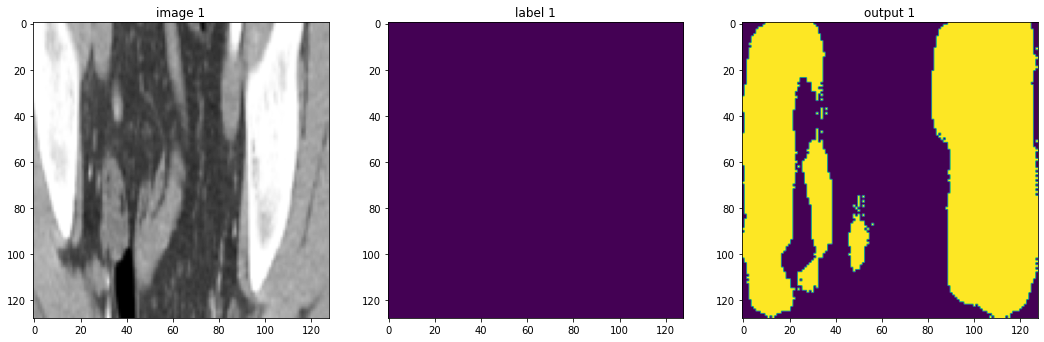

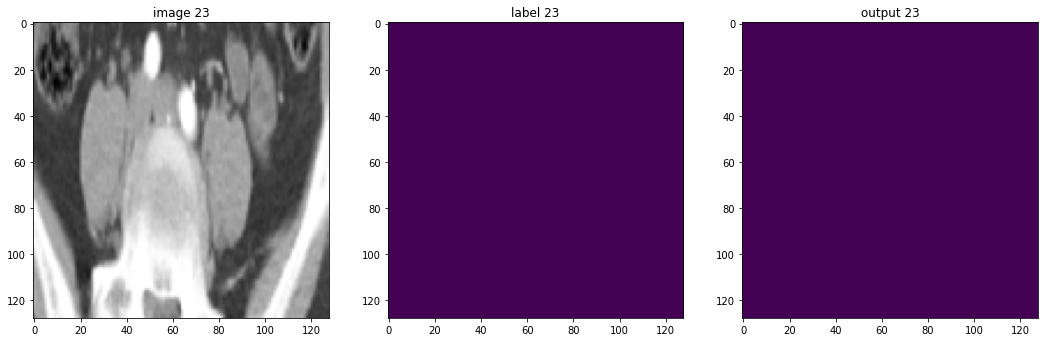

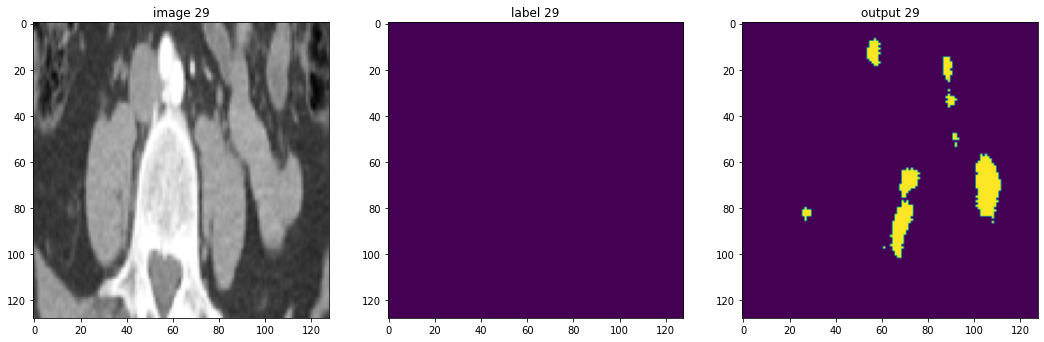

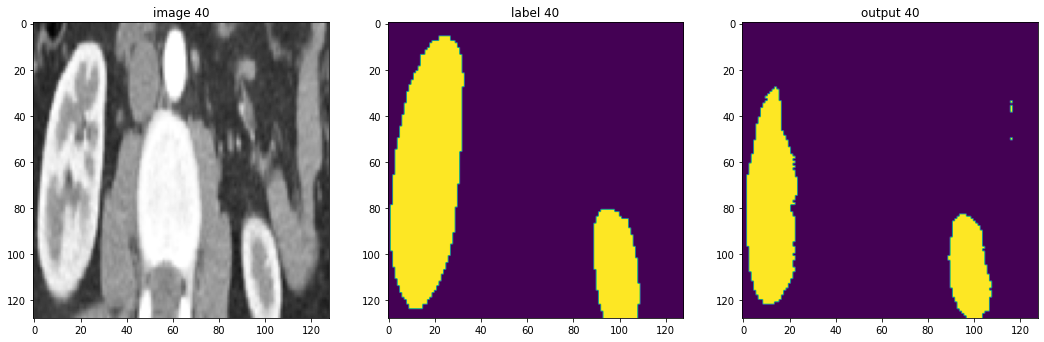

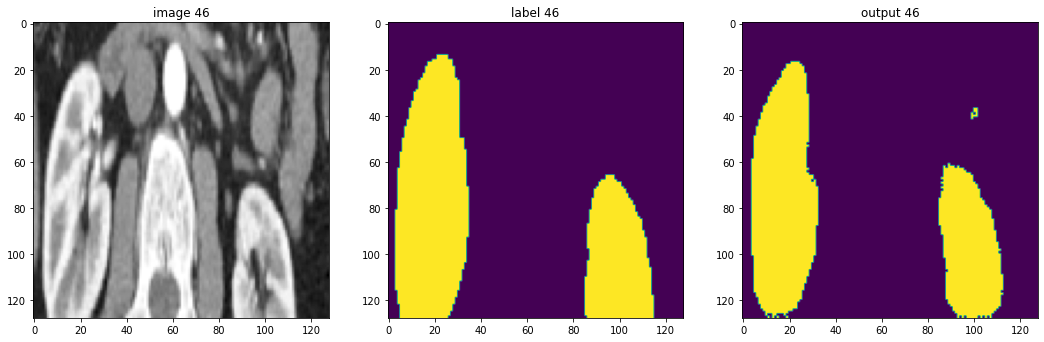

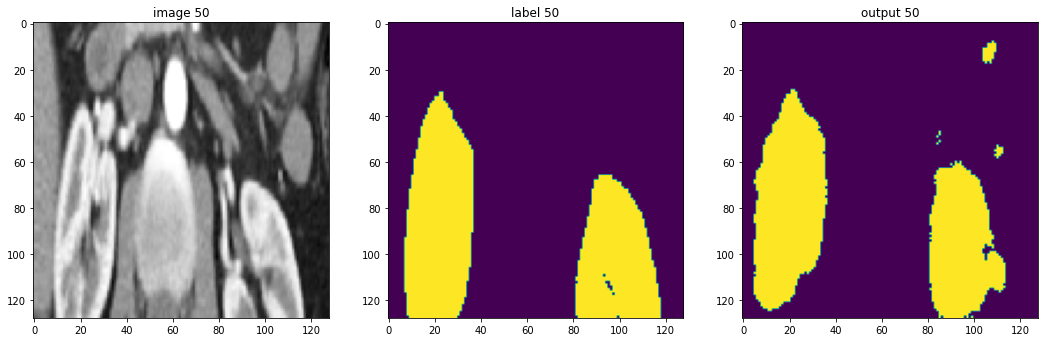

In [46]:
# after 85 epochs about 0.7 metric
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model_BBox.pth")))
model.eval()

with torch.no_grad():
    validation_patient = first(validation_loader)
    t_volume = validation_patient["vol"]

    validation_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    validation_outputs = sigmoid_activation(validation_outputs)
    validation_outputs = validation_outputs > 0.53

    
    for i in range(51):
        if i == 1 or i == 23 or i == 29 or i == 40 or i == 46 or i == 50:
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(validation_patient["vol"][0, 0, :, :, i], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(validation_patient["seg"][0, 0, :, :, i] != 0)
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(validation_outputs.detach().cpu()[0, 1, :, :, i])
            plt.show()